**Building Predictive Models - XGB Model**

In [ ]:
!pip install xgboost
!pip install scikit-learn

In [ ]:
#Loading the dataset
import pandas as pd
import numpy as ny
data = pd.read_csv('/content/train_cleaned.csv')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 774055 entries, 0 to 774054
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   outlet_city       774055 non-null  int64  
 1   luxury_sales      774055 non-null  float64
 2   fresh_sales       774055 non-null  float64
 3   dry_sales         774055 non-null  float64
 4   cluster_catgeory  774055 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 29.5 MB


In [ ]:
#Splitting train.csv into training and testing
from sklearn.model_selection import train_test_split


X = data.drop('cluster_catgeory', axis=1)
y = data['cluster_catgeory']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [ ]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [ ]:
print("Unique values in y_train:", y_train.unique())

Unique values in y_train: [1 2 5 3 4 6]


In [ ]:
#Since the model expecs all to be start from 0
y_train = y_train - 1
y_test = y_test - 1
print("Unique values in y_train:", y_train.unique())

Unique values in y_train: [0 1 4 2 3 5]


**Model Development**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [ ]:
# Define the base model with reduced complexity
xgb_model = XGBClassifier(
    n_estimators=50,  # Reduce trees to avoid overfitting
    max_depth=3,  # Lower depth for better generalization
    learning_rate=0.05,  # Smaller learning rate for smoother learning
    subsample=0.7,  # Reduce to prevent reliance on full dataset
    colsample_bytree=0.7,  # Less features per tree to reduce variance
    reg_lambda=10,  # Increase L2 regularization
    reg_alpha=0.5,  # Increase L1 regularization
    tree_method="hist",
    verbosity=1
)

In [ ]:
# Adjust the hyperparameter search space
param_grid = {
    'max_depth': [2, 3],  # Keeping it lower
    'learning_rate': [0.03, 0.05],  # Slower updates
    'n_estimators': [30, 50],  # Lower number of trees
    'subsample': [0.6, 0.7],  # Further reduced
    'colsample_bytree': [0.6, 0.7],
    'reg_lambda': [5, 10],  # Higher regularization
    'reg_alpha': [0.2, 0.5]
}

In [ ]:
# Use RandomizedSearchCV for faster tuning
random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_grid,
    n_iter=10,
    cv=3,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

In [ ]:
# Train the model
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=0.7, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None, n_estimators=50,
                                           n_jobs=None, num_parallel_tree=None,
                                           random_state=None, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.7],
                                        'learning_rate': [0.03, 0.05],
                                        'max_depth': [2, 3],
                                        'n_estimators': [30, 50],
                                        'reg_alpha': [0.2, 0.5],
                                        'reg_lambda': [5, 10],
                                        'subsample': [0.6, 0.7]},
                   scoring='accuracy', verbose=1)

In [ ]:
# Best parameters from RandomizedSearchCV
print("Best Hyperparameters:", random_search.best_params_)

Best Hyperparameters: {'subsample': 0.7, 'reg_lambda': 10, 'reg_alpha': 0.2, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.6}


In [ ]:
# Evaluate the best model
best_model = random_search.best_estimator_
y_pred_best = best_model.predict(X_test)

# Get accuracy
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"Best Model Accuracy: {accuracy_best * 100:.2f}%")

Best Model Accuracy: 92.96%


**Confusion Matrix**

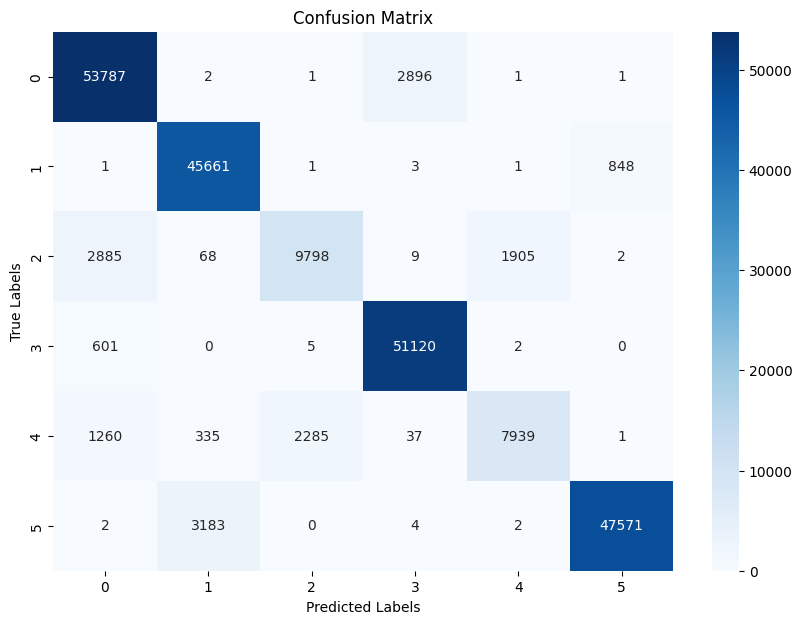

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(0, len(cm)), yticklabels=range(0, len(cm)))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


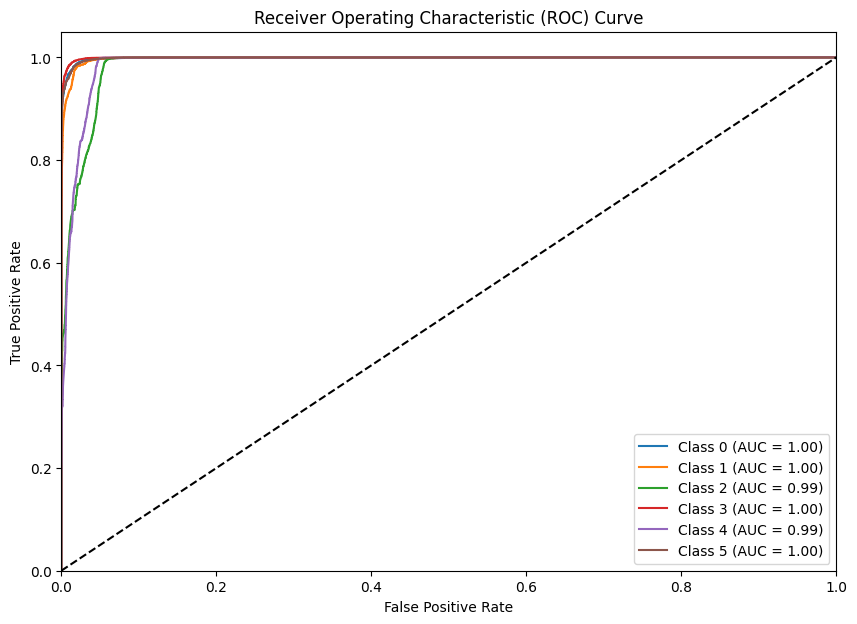

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Binarize the output labels for multi-class classification
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5])  # Modify as per your classes
y_pred_prob = best_model.predict_proba(X_test)  # Get the predicted probabilities for each class

# Calculate ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(cm)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve
plt.figure(figsize=(10, 7))
for i in range(len(cm)):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()



**AUC Score**

In [ ]:
# Calculate AUC Score
overall_auc = roc_auc_score(y_test_bin, y_pred_prob, average='macro', multi_class='ovr')
print(f'Overall AUC Score: {overall_auc:.4f}')


Overall AUC Score: 0.9950


In [ ]:
# Evaluate on the training set
y_train_pred = best_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

# Evaluate on the test set
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Training Accuracy: 92.95%
Test Accuracy: 92.96%


**Cross-Validation:**

In [ ]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

Cross-validation scores: [0.92917651 0.92851211 0.92746936 0.92881597 0.92841917]
Mean cross-validation score: 0.9284786232746496


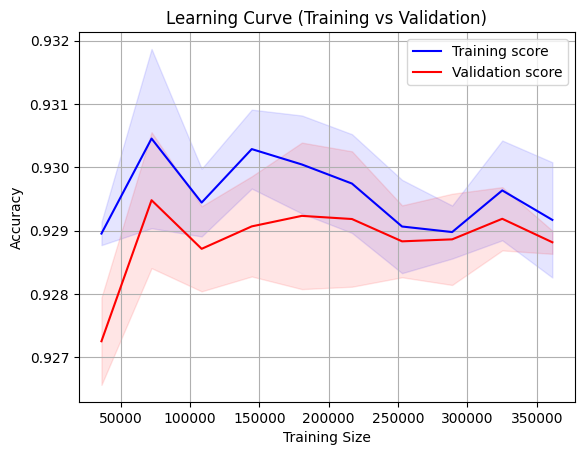

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
import numpy as np

# Generate learning curve data
train_sizes, train_scores, validation_scores = learning_curve(
    best_model, X_train, y_train, cv=3, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
)

# Calculate mean and standard deviation for train and validation scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(validation_scores, axis=1)
val_std = np.std(validation_scores, axis=1)

# Plotting the learning curve
plt.plot(train_sizes, train_mean, label="Training score", color="blue")
plt.plot(train_sizes, val_mean, label="Validation score", color="red")

# Fill the area between the mean +/- 1 std
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="blue")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color="red")

plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve (Training vs Validation)")
plt.legend(loc="best")
plt.grid(True)
plt.show()


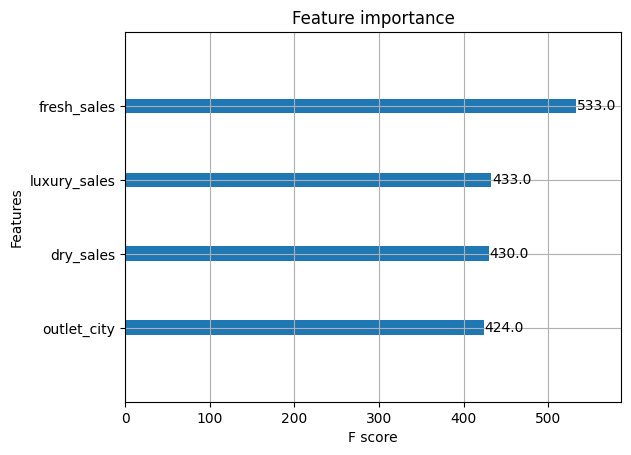

In [ ]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

# After fitting the model
plot_importance(best_model, importance_type='weight')  # Shows which features are most important
plt.show()


Checking With Real World Test Data

In [ ]:
#Loading the dataset
import pandas as pd
import numpy as ny
data = pd.read_csv('/content/train_cleaned.csv')